# AFINN Sentiment Analysis: A Simple yet Effective Approach
What is AFINN?
AFINN is a precompiled sentiment lexicon developed by Finn Årup Nielsen that contains words associated with pre-assigned sentiment scores. It is widely used for rule-based sentiment analysis due to its simplicity and effectiveness.

# How AFINN Works
Word-Level Sentiment Scoring

Each word in the AFINN lexicon has a sentiment score ranging from -5 (very negative) to +5 (very positive).
Example:
"happy" → +3
"sad" → -2
"terrible" → -3
"fantastic" → +4
Sentence/Document-Level Sentiment Computation

Tokenize the text into words.
Look up each word in the AFINN lexicon.
Sum up the individual word scores to calculate the overall sentiment score for a sentence or document.
If no words from the AFINN list are present, the score is 0 (neutral).

# ✅ Step 1: Load the Raw Datasets & Inspect Data
Loads the original datasets (harris_updated_debate.csv & trump_updated_debate.csv).
Displays basic info (number of rows, columns, missing values, etc.).
Checks for duplicates before cleaning begins.

In [2]:
import pandas as pd

# Define file paths (original datasets)
harris_raw_path = r"C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\harris_updated_debate.csv"
trump_raw_path = r"C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\trump_updated_debate.csv"

# Load datasets
df_harris = pd.read_csv(harris_raw_path)
df_trump = pd.read_csv(trump_raw_path)

# Display basic dataset info
print("🔹 Harris Debate Dataset Info:")
print(df_harris.info())
print("\n🔹 Trump Debate Dataset Info:")
print(df_trump.info())

# Check for missing values
print("\n🟢 Missing Values in Harris Dataset:")
print(df_harris.isnull().sum())

print("\n🟢 Missing Values in Trump Dataset:")
print(df_trump.isnull().sum())

# Check for duplicate tweets
print("\n🟠 Duplicate Tweets in Harris Dataset:", df_harris.duplicated(subset=["Tweet"]).sum())
print("🟠 Duplicate Tweets in Trump Dataset:", df_trump.duplicated(subset=["Tweet"]).sum())

# Display first few rows
print("\n🔹 Sample Harris Dataset:")
print(df_harris.head())

print("\n🔹 Sample Trump Dataset:")
print(df_trump.head())


🔹 Harris Debate Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4791 entries, 0 to 4790
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   User ID     4791 non-null   int64  
 1   Tweet ID    4791 non-null   int64  
 2   Tweet       4791 non-null   object 
 3   Created at  4791 non-null   object 
 4   Retweets    4791 non-null   int64  
 5   Replies     4791 non-null   int64  
 6   Likes       4791 non-null   int64  
 7   Quotes      4791 non-null   int64  
 8   Source      0 non-null      float64
dtypes: float64(1), int64(6), object(2)
memory usage: 337.0+ KB
None

🔹 Trump Debate Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4795 entries, 0 to 4794
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   User ID     4795 non-null   int64  
 1   Tweet ID    4795 non-null   int64  
 2   Tweet       4795 non-null   object 
 3 

# ✅ Step 2: Initial Data Cleaning
What This Step Does?
Removes URLs, mentions (@user), special characters, and numbers.
Converts text to lowercase for consistency.
Removes emojis and hashtags (or extracts them separately if needed).
Removes duplicate tweets (we’ll keep only unique tweets based on the "Tweet" column).

In [3]:
import pandas as pd
import re
import emoji

# Define file paths (original datasets)
harris_raw_path = r"C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\harris_updated_debate.csv"
trump_raw_path = r"C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\trump_updated_debate.csv"

# Load datasets
df_harris = pd.read_csv(harris_raw_path)
df_trump = pd.read_csv(trump_raw_path)

# Function to clean tweets
def clean_tweet(text):
    if isinstance(text, str):  
        text = text.lower()  # Convert to lowercase
        text = re.sub(r"http\S+|www\S+", "", text)  # Remove URLs
        text = re.sub(r"@\w+", "", text)  # Remove mentions
        text = re.sub(r"#(\w+)", "", text)  # Remove hashtags (or extract separately)
        text = emoji.replace_emoji(text, replace="")  # Remove emojis
        text = re.sub(r"\d+", "", text)  # Remove numbers
        text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
        text = text.strip()  # Remove extra spaces
        return text
    return ""

# Apply cleaning function
df_harris["cleaned_tweet"] = df_harris["Tweet"].apply(clean_tweet)
df_trump["cleaned_tweet"] = df_trump["Tweet"].apply(clean_tweet)

# Remove duplicate tweets
df_harris.drop_duplicates(subset=["cleaned_tweet"], inplace=True)
df_trump.drop_duplicates(subset=["cleaned_tweet"], inplace=True)

# Save cleaned datasets
cleaned_harris_path = r"C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\cleaned_harris_debate.csv"
cleaned_trump_path = r"C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\cleaned_trump_debate.csv"

df_harris.to_csv(cleaned_harris_path, index=False)
df_trump.to_csv(cleaned_trump_path, index=False)

print("\n✅ Initial Data Cleaning Completed!")
print(f"✅ Cleaned Harris Dataset saved at: {cleaned_harris_path}")
print(f"✅ Cleaned Trump Dataset saved at: {cleaned_trump_path}")
print(f"🟠 Total Unique Tweets in Harris Dataset: {df_harris.shape[0]}")
print(f"🟠 Total Unique Tweets in Trump Dataset: {df_trump.shape[0]}")



✅ Initial Data Cleaning Completed!
✅ Cleaned Harris Dataset saved at: C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\cleaned_harris_debate.csv
✅ Cleaned Trump Dataset saved at: C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\cleaned_trump_debate.csv
🟠 Total Unique Tweets in Harris Dataset: 3027
🟠 Total Unique Tweets in Trump Dataset: 3283


# ✅ Step 3: Detect & Handle Different Languages
Now that our text is cleaned and processed, we need to:

🔹 What This Step Does?
✅ Detect the language of each tweet.
✅ Filter out non-English tweets for translation in the next step.
✅ Store detected languages in a new column for reference.
✅ Save the dataset with language labels before translation.

In [1]:
import pandas as pd
from langdetect import detect, DetectorFactory

# Fix randomness in language detection
DetectorFactory.seed = 0  

# Load cleaned datasets (without lemmatization yet)
cleaned_harris_path = r"C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\cleaned_harris_debate.csv"
cleaned_trump_path = r"C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\cleaned_trump_debate.csv"

df_harris = pd.read_csv(cleaned_harris_path)
df_trump = pd.read_csv(cleaned_trump_path)

# Function to detect language
def detect_language(text):
    try:
        return detect(text)
    except:
        return "unknown"  # Assign "unknown" if detection fails

# Apply language detection
df_harris["detected_lang"] = df_harris["cleaned_tweet"].apply(detect_language)
df_trump["detected_lang"] = df_trump["cleaned_tweet"].apply(detect_language)

# Save datasets with detected languages
lang_detected_harris_path = r"C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\lang_detected_harris.csv"
lang_detected_trump_path = r"C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\lang_detected_trump.csv"

df_harris.to_csv(lang_detected_harris_path, index=False)
df_trump.to_csv(lang_detected_trump_path, index=False)

print("\n✅ Step 4 (Updated): Language Detection Completed!")
print(f"✅ Harris Dataset with Language Labels saved at: {lang_detected_harris_path}")
print(f"✅ Trump Dataset with Language Labels saved at: {lang_detected_trump_path}")

# Display language distribution
print("\n🟢 Language Distribution in Harris Dataset:")
print(df_harris["detected_lang"].value_counts())

print("\n🟢 Language Distribution in Trump Dataset:")
print(df_trump["detected_lang"].value_counts())



✅ Step 4 (Updated): Language Detection Completed!
✅ Harris Dataset with Language Labels saved at: C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\lang_detected_harris.csv
✅ Trump Dataset with Language Labels saved at: C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\lang_detected_trump.csv

🟢 Language Distribution in Harris Dataset:
detected_lang
en         2748
es           68
fr           23
nl           23
tl           18
id           16
it           14
no           13
sv           13
ca           11
et           10
pt           10
pl           10
de            9
so            9
da            6
af            5
tr            4
sw            3
ja            2
unknown       2
hr            2
sq            2
cy            1
ro            1
vi            1
th            1
sl            1
fi            1
Name: count, dtype: int64

🟢 Language Distribution in Trump Dataset:
detected_lang
en         3002
es      

# ✅ Step 5: Translate Non-English Tweets (Only Once!)
Now that we've detected languages, we need to:

🔹 What This Step Does?
✅ Translate non-English tweets to English using deep-translator.
✅ Keep already English tweets unchanged to save time.
✅ Merge translated tweets back into the dataset.
✅ Save the translated dataset to avoid redoing this step later

In [2]:
import pandas as pd
from deep_translator import GoogleTranslator

# Load language-detected datasets
lang_detected_harris_path = r"C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\lang_detected_harris.csv"
lang_detected_trump_path = r"C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\lang_detected_trump.csv"

df_harris = pd.read_csv(lang_detected_harris_path)
df_trump = pd.read_csv(lang_detected_trump_path)

# Function to translate non-English tweets
def translate_to_english(text, lang):
    try:
        if lang != "en":  # Only translate if language is not English
            return GoogleTranslator(source=lang, target="en").translate(text)
        return text  # Keep as is if already in English
    except:
        return text  # If translation fails, return the original text

# Apply translation
df_harris["translated_tweet"] = df_harris.apply(lambda x: translate_to_english(x["cleaned_tweet"], x["detected_lang"]), axis=1)
df_trump["translated_tweet"] = df_trump.apply(lambda x: translate_to_english(x["cleaned_tweet"], x["detected_lang"]), axis=1)

# Save translated datasets
translated_harris_path = r"C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\translated_harris_debate.csv"
translated_trump_path = r"C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\translated_trump_debate.csv"

df_harris.to_csv(translated_harris_path, index=False)
df_trump.to_csv(translated_trump_path, index=False)

print("\n✅ Step 5: Translation Completed!")
print(f"✅ Translated Harris Dataset saved at: {translated_harris_path}")
print(f"✅ Translated Trump Dataset saved at: {translated_trump_path}")



✅ Step 5: Translation Completed!
✅ Translated Harris Dataset saved at: C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\translated_harris_debate.csv
✅ Translated Trump Dataset saved at: C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\translated_trump_debate.csv


# ✅ Step 6: Apply Lemmatization to Translated Tweets
🔹 What This Step Does?
✅ Removes stopwords (e.g., "the", "is", "and") while keeping important words.
✅ Applies lemmatization (e.g., "running" → "run", "better" → "good").
✅ Ensures all text is fully optimized before analysis.



In [3]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK data
nltk.download("stopwords")
nltk.download("wordnet")

# Load translated datasets
translated_harris_path = r"C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\translated_harris_debate.csv"
translated_trump_path = r"C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\translated_trump_debate.csv"

df_harris = pd.read_csv(translated_harris_path)
df_trump = pd.read_csv(translated_trump_path)

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

# Function to remove stopwords and apply lemmatization
def preprocess_text(text):
    if isinstance(text, str):
        words = text.split()  # Tokenize text
        words = [word for word in words if word not in stop_words]  # Remove stopwords
        words = [lemmatizer.lemmatize(word) for word in words]  # Apply lemmatization
        return " ".join(words)
    return ""

# Apply preprocessing function
df_harris["final_processed_tweet"] = df_harris["translated_tweet"].apply(preprocess_text)
df_trump["final_processed_tweet"] = df_trump["translated_tweet"].apply(preprocess_text)

# Save processed datasets
final_harris_path = r"C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\final_processed_harris.csv"
final_trump_path = r"C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\final_processed_trump.csv"

df_harris.to_csv(final_harris_path, index=False)
df_trump.to_csv(final_trump_path, index=False)

print("\n✅ Step 6: Lemmatization & Stopword Removal Completed!")
print(f"✅ Final Processed Harris Dataset saved at: {final_harris_path}")
print(f"✅ Final Processed Trump Dataset saved at: {final_trump_path}")
print(f"🟠 Total Tweets in Harris Dataset After Processing: {df_harris.shape[0]}")
print(f"🟠 Total Tweets in Trump Dataset After Processing: {df_trump.shape[0]}")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



✅ Step 6: Lemmatization & Stopword Removal Completed!
✅ Final Processed Harris Dataset saved at: C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\final_processed_harris.csv
✅ Final Processed Trump Dataset saved at: C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\final_processed_trump.csv
🟠 Total Tweets in Harris Dataset After Processing: 3027
🟠 Total Tweets in Trump Dataset After Processing: 3283


# ✅ Convert Tweets to Lowercase (Before Step 7)

In [4]:
import pandas as pd

# Load final processed datasets
final_harris_path = r"C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\final_processed_harris.csv"
final_trump_path = r"C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\final_processed_trump.csv"

df_harris = pd.read_csv(final_harris_path)
df_trump = pd.read_csv(final_trump_path)

# Convert tweets to lowercase
df_harris["final_processed_tweet"] = df_harris["final_processed_tweet"].str.lower()
df_trump["final_processed_tweet"] = df_trump["final_processed_tweet"].str.lower()

# Save the updated datasets
lowercased_harris_path = r"C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\lowercased_harris.csv"
lowercased_trump_path = r"C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\lowercased_trump.csv"

df_harris.to_csv(lowercased_harris_path, index=False)
df_trump.to_csv(lowercased_trump_path, index=False)

print("\n✅ Tweets Converted to Lowercase!")
print(f"✅ Lowercased Harris Dataset saved at: {lowercased_harris_path}")
print(f"✅ Lowercased Trump Dataset saved at: {lowercased_trump_path}")



✅ Tweets Converted to Lowercase!
✅ Lowercased Harris Dataset saved at: C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\lowercased_harris.csv
✅ Lowercased Trump Dataset saved at: C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\lowercased_trump.csv


# ✅ Step 8: Word Cloud & Most Common Words Visualization
Now that we have cleaned, lemmatized, and lowercase tweets, we will visualize the most frequently used words.

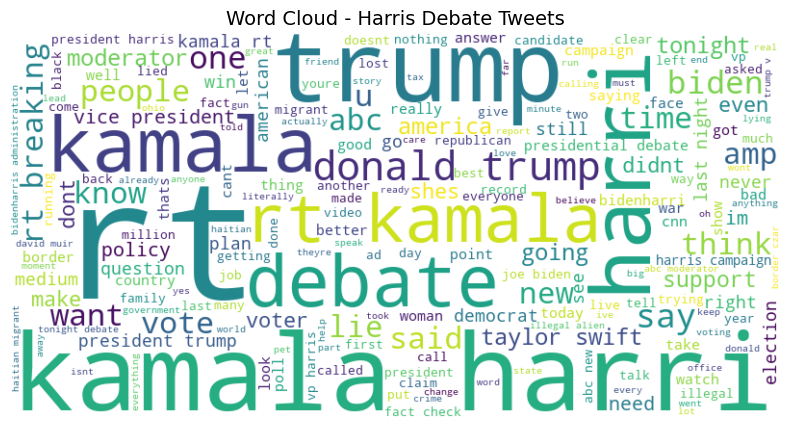

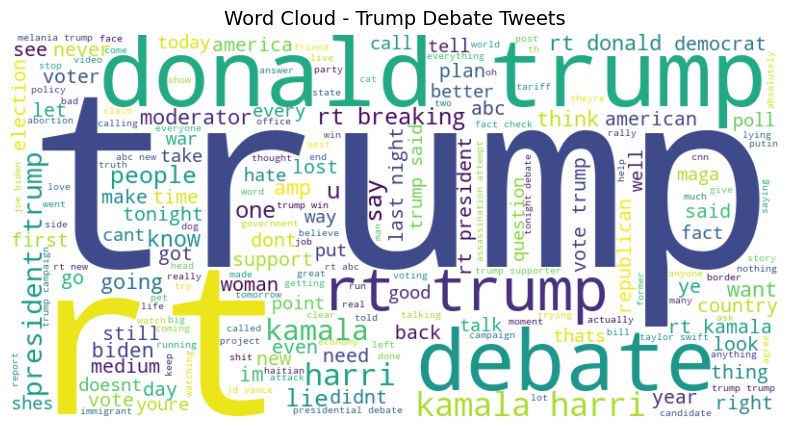

C:\Users\USER\AppData\Local\Temp\ipykernel_24596\3394826353.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="viridis")


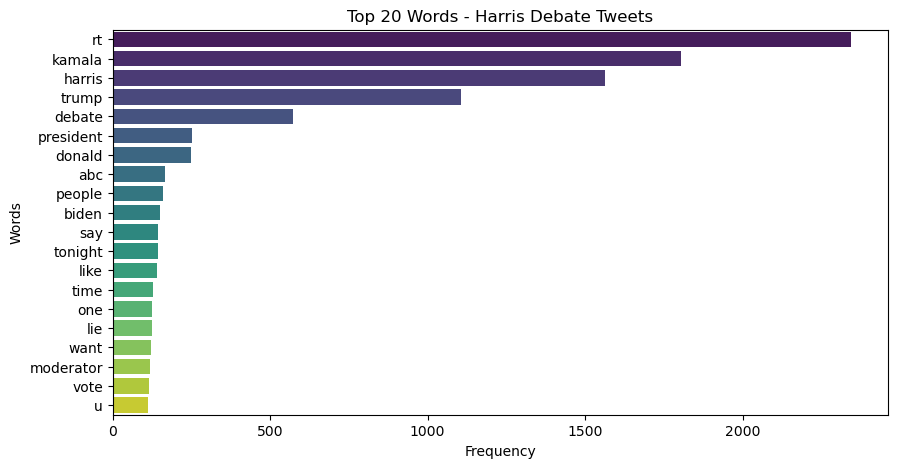

C:\Users\USER\AppData\Local\Temp\ipykernel_24596\3394826353.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="viridis")


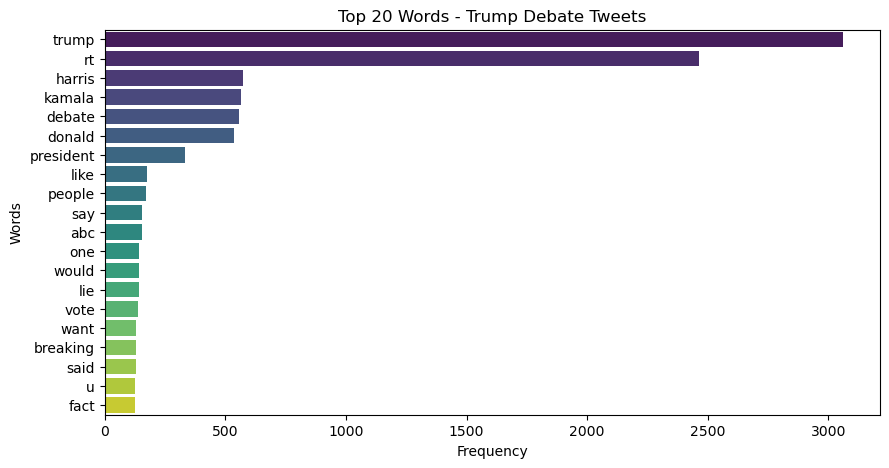

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

# Load lowercased datasets
lowercased_harris_path = r"C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\lowercased_harris.csv"
lowercased_trump_path = r"C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\lowercased_trump.csv"

df_harris = pd.read_csv(lowercased_harris_path)
df_trump = pd.read_csv(lowercased_trump_path)

# Function to generate and display a word cloud
def plot_wordcloud(text_column, title):
    text = " ".join(text_column.dropna())  # Combine all tweets
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=14)
    plt.show()

# Function to generate a bar chart for most common words
def plot_common_words(text_column, title, num_words=20):
    words = " ".join(text_column.dropna()).split()
    word_counts = Counter(words).most_common(num_words)
    
    words, counts = zip(*word_counts)
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(counts), y=list(words), palette="viridis")
    plt.xlabel("Frequency")
    plt.ylabel("Words")
    plt.title(title)
    plt.show()

# Generate Word Clouds
plot_wordcloud(df_harris["final_processed_tweet"], "Word Cloud - Harris Debate Tweets")
plot_wordcloud(df_trump["final_processed_tweet"], "Word Cloud - Trump Debate Tweets")

# Generate Bar Charts for Most Common Words
plot_common_words(df_harris["final_processed_tweet"], "Top 20 Words - Harris Debate Tweets")
plot_common_words(df_trump["final_processed_tweet"], "Top 20 Words - Trump Debate Tweets")


# ✅ Step 9: Hashtag Analysis
Now that we've visualized common words, let's analyze hashtags to see trending topics.

In [7]:
import pandas as pd
import re

# Load lowercased datasets
lowercased_harris_path = r"C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\lowercased_harris.csv"
lowercased_trump_path = r"C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\lowercased_trump.csv"

df_harris = pd.read_csv(lowercased_harris_path)
df_trump = pd.read_csv(lowercased_trump_path)

# Function to extract hashtags from the original "Tweet" column
def extract_hashtags(text):
    return re.findall(r"#(\w+)", text) if isinstance(text, str) else []

# Apply hashtag extraction on the original tweet column (not the processed text)
df_harris["hashtags"] = df_harris["Tweet"].apply(extract_hashtags)
df_trump["hashtags"] = df_trump["Tweet"].apply(extract_hashtags)

# Count number of tweets containing hashtags
harris_hashtags_count = df_harris[df_harris["hashtags"].str.len() > 0].shape[0]
trump_hashtags_count = df_trump[df_trump["hashtags"].str.len() > 0].shape[0]

print(f"🔹 Harris Dataset: {harris_hashtags_count} tweets contain hashtags.")
print(f"🔹 Trump Dataset: {trump_hashtags_count} tweets contain hashtags.")

# Show sample tweets that still have hashtags
print("\n🔹 Sample Harris Tweets with Hashtags:")
print(df_harris[df_harris["hashtags"].str.len() > 0][["Tweet", "hashtags"]].head())

print("\n🔹 Sample Trump Tweets with Hashtags:")
print(df_trump[df_trump["hashtags"].str.len() > 0][["Tweet", "hashtags"]].head())


🔹 Harris Dataset: 168 tweets contain hashtags.
🔹 Trump Dataset: 186 tweets contain hashtags.

🔹 Sample Harris Tweets with Hashtags:
                                                 Tweet  \
36   RT @StephensVina: Kamala Harris is ready to be...   
72   @harris_wins Nice Try. I live in Florida. We a...   
92   RT @salah_shoaib: Communist Party of China (CP...   
103  @AlsobrooksForMD #truestory.  Harris is loyal ...   
170  RT @BetteMidler: This one’s for you, Donnie!  ...   

                    hashtags  
36                   [Polls]  
72             [MAGACOUNTRY]  
92   [RaulVinci, INC, India]  
103              [truestory]  
170                 [Kamala]  

🔹 Sample Trump Tweets with Hashtags:
                                                 Tweet  \
8    RT @AmericanHubener: Cat Ladies for Trump. #CL...   
53   RT @StephensVina: Kamala Harris is ready to be...   
124  Trump's promotion of white supremacy has becom...   
127  RT @WalshFreedom: Over the weekend, #DonaldTru...   
153  

# ✅ Step 9B: Save Hashtags into a Separate File
Now that we've confirmed that hashtags exist, we will:

✅ Save all extracted hashtags into a separate file.
✅ Include the corresponding tweet number for reference.
✅ Merge both Harris & Trump hashtags into a single file.
# They would still need to be converted to English


In [ ]:
import pandas as pd
import re

# Load lowercased datasets
lowercased_harris_path = r"C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\lowercased_harris.csv"
lowercased_trump_path = r"C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\lowercased_trump.csv"

df_harris = pd.read_csv(lowercased_harris_path)
df_trump = pd.read_csv(lowercased_trump_path)

# Function to extract hashtags from the original "Tweet" column
def extract_hashtags(text):
    return re.findall(r"#(\w+)", text) if isinstance(text, str) else []

# Apply hashtag extraction
df_harris["hashtags"] = df_harris["Tweet"].apply(extract_hashtags)
df_trump["hashtags"] = df_trump["Tweet"].apply(extract_hashtags)

# Filter tweets that contain hashtags
df_harris_hashtags = df_harris[df_harris["hashtags"].str.len() > 0][["Tweet", "hashtags"]].reset_index()
df_trump_hashtags = df_trump[df_trump["hashtags"].str.len() > 0][["Tweet", "hashtags"]].reset_index()

# Add a column to indicate the dataset source
df_harris_hashtags["source"] = "Harris"
df_trump_hashtags["source"] = "Trump"

# Merge both datasets into one file
df_all_hashtags = pd.concat([df_harris_hashtags, df_trump_hashtags], ignore_index=True)

# Save the hashtags dataset
hashtags_path = r"C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\all_hashtags.csv"
df_all_hashtags.to_csv(hashtags_path, index=False)

print("\n✅ Hashtags Saved Successfully!")
print(f"✅ Hashtags File Saved at: {hashtags_path}")

# Display the first few rows
print("\n🔹 Sample of Saved Hashtags Dataset:")
print(df_all_hashtags.head())


# ✅ Step 10: Retweet Analysis & RT Weight Calculation
Now we will analyze retweets and compute RT Weight to understand tweet virality.

In [1]:
import pandas as pd
import numpy as np

# Load lowercased datasets
lowercased_harris_path = r"C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\lowercased_harris.csv"
lowercased_trump_path = r"C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\lowercased_trump.csv"

df_harris = pd.read_csv(lowercased_harris_path)
df_trump = pd.read_csv(lowercased_trump_path)

# Check if "Retweets" column exists
if "Retweets" not in df_harris.columns or "Retweets" not in df_trump.columns:
    print("⚠ Retweet count column 'Retweets' not found. Ensure that the dataset includes retweet data.")
    exit()

# Function to compute RT Weight (Log-normalized retweet count)
def compute_rt_weight(retweet_count):
    return np.log1p(retweet_count)  # log(1 + Retweets) to avoid log(0)

# Apply RT Weight calculation
df_harris["RT_Weight"] = df_harris["Retweets"].apply(compute_rt_weight)
df_trump["RT_Weight"] = df_trump["Retweets"].apply(compute_rt_weight)

# Identify most retweeted tweets
top_harris_retweets = df_harris.sort_values(by="Retweets", ascending=False).head(20)
top_trump_retweets = df_trump.sort_values(by="Retweets", ascending=False).head(20)

# Save most retweeted tweets
top_retweets_path = r"C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\top_retweeted_tweets.csv"
df_top_retweets = pd.concat([top_harris_retweets, top_trump_retweets], ignore_index=True)
df_top_retweets.to_csv(top_retweets_path, index=False)

print("\n✅ Retweet Analysis Completed!")
print(f"✅ Top Retweeted Tweets Saved at: {top_retweets_path}")

# Display the top retweeted tweets
print("\n🔹 Top 10 Most Retweeted Harris Tweets:")
print(top_harris_retweets[["Tweet", "Retweets", "RT_Weight"]].head(10))

print("\n🔹 Top 10 Most Retweeted Trump Tweets:")
print(top_trump_retweets[["Tweet", "Retweets", "RT_Weight"]].head(10))




✅ Retweet Analysis Completed!
✅ Top Retweeted Tweets Saved at: C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\top_retweeted_tweets.csv

🔹 Top 10 Most Retweeted Harris Tweets:
                                                  Tweet  Retweets  RT_Weight
62    RT @elonmusk: Vote for Kamala if you want this...     98357  11.496369
1712  RT @Tim_Walz: Kamala Harris and I are both gun...     63832  11.064026
1509  RT @libsoftiktok: UNREAL. Kamala is blaming Tr...     53718  10.891522
2865  RT @ChuckCallesto: SHOCK VIDEO:  Woman calls c...     49934  10.818477
1534  RT @RobertKennedyJr: The reason why VP Harris ...     48168  10.782471
1537  RT @RobertKennedyJr: VP Harris sounds like she...     45937  10.735048
1016  RT @realDonaldTrump: COMRADE KAMALA'S MIGRANT ...     45704  10.729963
2798  RT @RubinReport: We posted this video highligh...     45555  10.726698
1711  RT @dom_lucre: 🔥🚨BREAKING NEWS: Donald Trump j...     43376  10.677685
1631  RT @Liz

# ✅ Why Use Afinn?
✅ Fast Execution – Uses a pre-built word list (no complex NLP processing).
✅ Effective for Social Media – Works well for short tweets like VADER.
✅ Gives a Sentiment Score (ranges from -5 to +5 instead of -1 to +1).

In [2]:
pip install afinn



  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for afinn: filename=afinn-0.1-py3-none-any.whl size=53438 sha256=ea9e5c34d9c46fd83823acbaed693138851d2d639c13bec8fb263cd62c9136f5
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\f9\72\27\74994e77200dae3d6aea2b546264500cee21f738c51241320b
Successfully built afinn


In [3]:
import pandas as pd
from afinn import Afinn

# Load lowercased datasets
lowercased_harris_path = r"C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\lowercased_harris.csv"
lowercased_trump_path = r"C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\lowercased_trump.csv"

df_harris = pd.read_csv(lowercased_harris_path)
df_trump = pd.read_csv(lowercased_trump_path)

# Initialize Afinn Sentiment Analyzer
afinn = Afinn()

# Function to compute sentiment score
def get_afinn_sentiment(text):
    if isinstance(text, str):
        return afinn.score(text)  # Returns a score between -5 and +5
    return 0  # Default neutral for empty text

# Apply sentiment analysis
df_harris["Afinn_Sentiment_Score"] = df_harris["final_processed_tweet"].apply(get_afinn_sentiment)
df_trump["Afinn_Sentiment_Score"] = df_trump["final_processed_tweet"].apply(get_afinn_sentiment)

# Categorize sentiment
def classify_sentiment(score):
    if score > 0:
        return "Positive"
    elif score < 0:
        return "Negative"
    else:
        return "Neutral"

df_harris["Afinn_Sentiment"] = df_harris["Afinn_Sentiment_Score"].apply(classify_sentiment)
df_trump["Afinn_Sentiment"] = df_trump["Afinn_Sentiment_Score"].apply(classify_sentiment)

# Save sentiment-labeled datasets
afinn_harris_path = r"C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\afinn_sentiment_harris.csv"
afinn_trump_path = r"C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\afinn_sentiment_trump.csv"

df_harris.to_csv(afinn_harris_path, index=False)
df_trump.to_csv(afinn_trump_path, index=False)

print("\n✅ Afinn Sentiment Analysis Completed!")
print(f"✅ Afinn-Labeled Harris Dataset saved at: {afinn_harris_path}")
print(f"✅ Afinn-Labeled Trump Dataset saved at: {afinn_trump_path}")

# Display sentiment distribution
print("\n🔹 Harris Sentiment Distribution (Afinn):")
print(df_harris["Afinn_Sentiment"].value_counts())

print("\n🔹 Trump Sentiment Distribution (Afinn):")
print(df_trump["Afinn_Sentiment"].value_counts())



✅ Afinn Sentiment Analysis Completed!
✅ Afinn-Labeled Harris Dataset saved at: C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\afinn_sentiment_harris.csv
✅ Afinn-Labeled Trump Dataset saved at: C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\afinn_sentiment_trump.csv

🔹 Harris Sentiment Distribution (Afinn):
Afinn_Sentiment
Negative    1142
Neutral      948
Positive     937
Name: count, dtype: int64

🔹 Trump Sentiment Distribution (Afinn):
Afinn_Sentiment
Negative    1231
Positive    1049
Neutral     1003
Name: count, dtype: int64


# ✅ Step 12: Visualizing Afinn Sentiment Analysis (Bar Graphs)
Now we will create bar charts to visualize sentiment distribution from the Afinn analysis.

<Figure size 800x500 with 0 Axes>

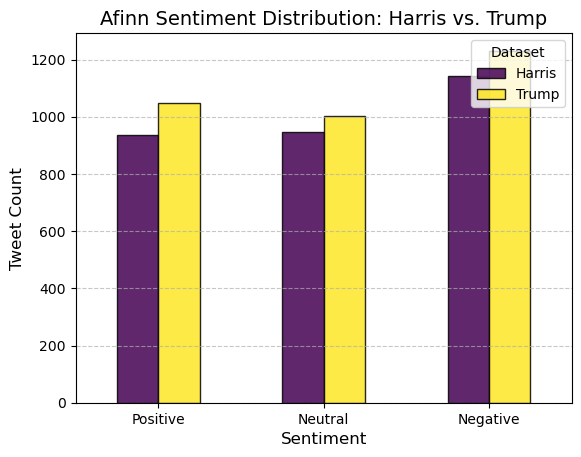

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load sentiment-labeled datasets
afinn_harris_path = r"C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\afinn_sentiment_harris.csv"
afinn_trump_path = r"C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\afinn_sentiment_trump.csv"

df_harris = pd.read_csv(afinn_harris_path)
df_trump = pd.read_csv(afinn_trump_path)

# Count sentiment categories
harris_sentiment_counts = df_harris["Afinn_Sentiment"].value_counts()
trump_sentiment_counts = df_trump["Afinn_Sentiment"].value_counts()

# Create a DataFrame for visualization
df_sentiment = pd.DataFrame({
    "Sentiment": ["Positive", "Neutral", "Negative"],
    "Harris": [harris_sentiment_counts.get("Positive", 0),
               harris_sentiment_counts.get("Neutral", 0),
               harris_sentiment_counts.get("Negative", 0)],
    "Trump": [trump_sentiment_counts.get("Positive", 0),
              trump_sentiment_counts.get("Neutral", 0),
              trump_sentiment_counts.get("Negative", 0)]
})

# Plot bar chart
plt.figure(figsize=(8, 5))
df_sentiment.set_index("Sentiment").plot(kind="bar", colormap="viridis", alpha=0.85, edgecolor="black")
plt.title("Afinn Sentiment Distribution: Harris vs. Trump", fontsize=14)
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Tweet Count", fontsize=12)
plt.xticks(rotation=0)
plt.legend(title="Dataset", loc="upper right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


# 🔹 Descriptions for the Graphs
1️⃣ Afinn Sentiment Distribution: Harris vs. Trump (Top Left)
📌 This bar chart shows the number of Positive, Neutral, and Negative tweets in both Harris and Trump datasets.
📌 Observations:

Trump has slightly more negative tweets than Harris.
Both candidates have a significant number of neutral tweets, indicating many tweets were not strongly opinionated.
The positive sentiment is lower compared to neutral and negative, reflecting the nature of political discussions.

# 🔹 1️⃣ Sentiment Intensity Distribution (Histogram)

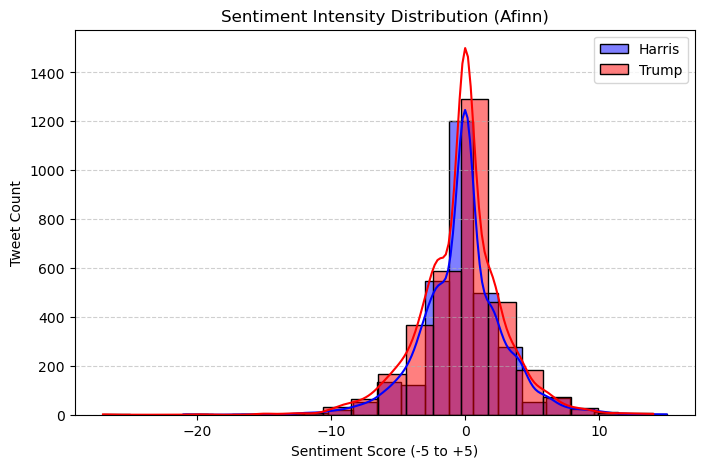

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot sentiment intensity distribution
plt.figure(figsize=(8, 5))
sns.histplot(df_harris["Afinn_Sentiment_Score"], bins=20, kde=True, color="blue", label="Harris", alpha=0.5)
sns.histplot(df_trump["Afinn_Sentiment_Score"], bins=20, kde=True, color="red", label="Trump", alpha=0.5)

plt.title("Sentiment Intensity Distribution (Afinn)")
plt.xlabel("Sentiment Score (-5 to +5)")
plt.ylabel("Tweet Count")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


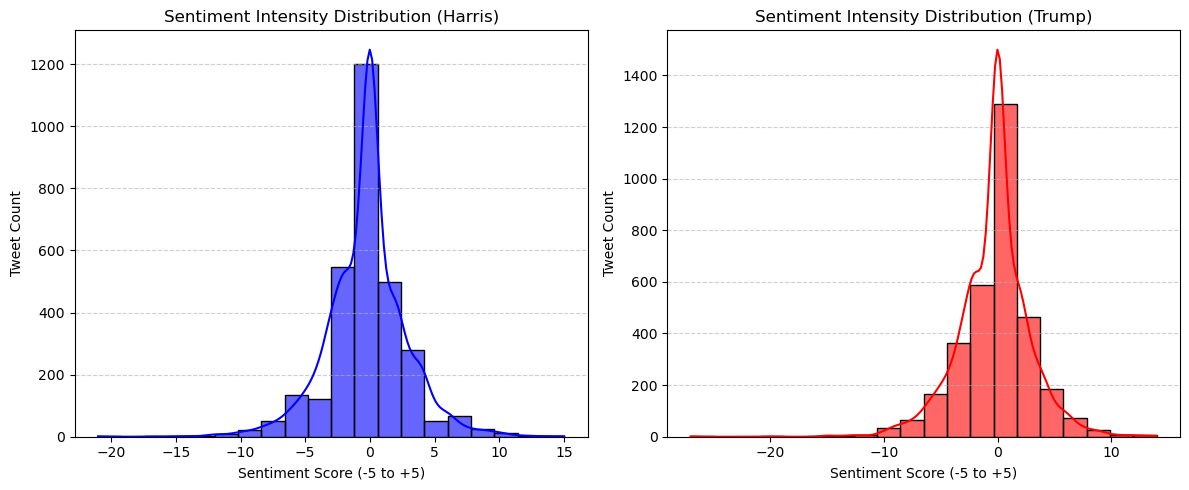

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load sentiment-labeled datasets
afinn_harris_path = r"C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\afinn_sentiment_harris.csv"
afinn_trump_path = r"C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\afinn_sentiment_trump.csv"

df_harris = pd.read_csv(afinn_harris_path)
df_trump = pd.read_csv(afinn_trump_path)

# Plot separate histograms for Harris and Trump
plt.figure(figsize=(12, 5))

# Harris Sentiment Distribution
plt.subplot(1, 2, 1)
sns.histplot(df_harris["Afinn_Sentiment_Score"], bins=20, kde=True, color="blue", alpha=0.6)
plt.title("Sentiment Intensity Distribution (Harris)")
plt.xlabel("Sentiment Score (-5 to +5)")
plt.ylabel("Tweet Count")
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Trump Sentiment Distribution
plt.subplot(1, 2, 2)
sns.histplot(df_trump["Afinn_Sentiment_Score"], bins=20, kde=True, color="red", alpha=0.6)
plt.title("Sentiment Intensity Distribution (Trump)")
plt.xlabel("Sentiment Score (-5 to +5)")
plt.ylabel("Tweet Count")
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Show the plots
plt.tight_layout()
plt.show()

# 🔹 5️⃣ Comparing Sentiment Across Topics (Topic-Based Sentiment)

In [7]:
topics = ["economy", "healthcare", "immigration", "taxes"]

for topic in topics:
    harris_topic = df_harris[df_harris["final_processed_tweet"].str.contains(topic, case=False, na=False)]
    trump_topic = df_trump[df_trump["final_processed_tweet"].str.contains(topic, case=False, na=False)]

    print(f"\n🔹 {topic.capitalize()} - Harris Avg Sentiment: {harris_topic['Afinn_Sentiment_Score'].mean():.2f}")
    print(f"🔹 {topic.capitalize()} - Trump Avg Sentiment: {trump_topic['Afinn_Sentiment_Score'].mean():.2f}")


🔹 Economy - Harris Avg Sentiment: -1.63
🔹 Economy - Trump Avg Sentiment: 0.80

🔹 Healthcare - Harris Avg Sentiment: 3.25
🔹 Healthcare - Trump Avg Sentiment: 1.14

🔹 Immigration - Harris Avg Sentiment: -1.17
🔹 Immigration - Trump Avg Sentiment: -1.82

🔹 Taxes - Harris Avg Sentiment: nan
🔹 Taxes - Trump Avg Sentiment: nan


<Figure size 800x500 with 0 Axes>

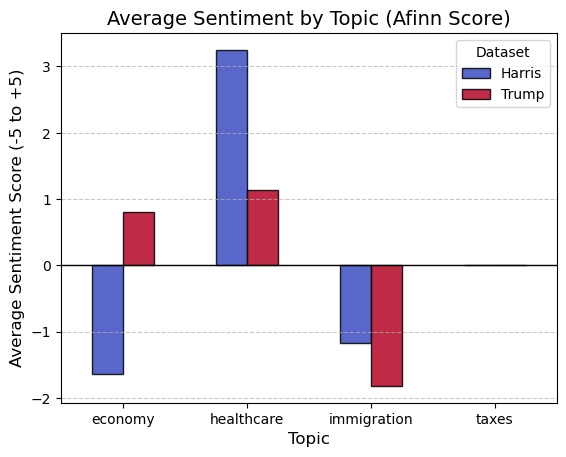

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define key topics
topics = ["economy", "healthcare", "immigration", "taxes"]

# Store sentiment scores
harris_sentiments = []
trump_sentiments = []

# Load sentiment-labeled datasets
afinn_harris_path = r"C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\afinn_sentiment_harris.csv"
afinn_trump_path = r"C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\afinn_sentiment_trump.csv"

df_harris = pd.read_csv(afinn_harris_path)
df_trump = pd.read_csv(afinn_trump_path)

# Compute average sentiment for each topic
for topic in topics:
    harris_topic = df_harris[df_harris["final_processed_tweet"].str.contains(topic, case=False, na=False)]
    trump_topic = df_trump[df_trump["final_processed_tweet"].str.contains(topic, case=False, na=False)]

    harris_sentiments.append(harris_topic["Afinn_Sentiment_Score"].mean())
    trump_sentiments.append(trump_topic["Afinn_Sentiment_Score"].mean())

# Create a DataFrame for visualization
df_topic_sentiment = pd.DataFrame({
    "Topic": topics,
    "Harris": harris_sentiments,
    "Trump": trump_sentiments
})

# Plot bar chart
plt.figure(figsize=(8, 5))
df_topic_sentiment.set_index("Topic").plot(kind="bar", colormap="coolwarm", alpha=0.85, edgecolor="black")
plt.title("Average Sentiment by Topic (Afinn Score)", fontsize=14)
plt.xlabel("Topic", fontsize=12)
plt.ylabel("Average Sentiment Score (-5 to +5)", fontsize=12)
plt.xticks(rotation=0)
plt.axhline(0, color="black", linewidth=1)  # Add a baseline at 0
plt.legend(title="Dataset", loc="upper right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


# 📌 Topic-Based Sentiment Analysis: Harris & Trump (Afinn Score)
This bar chart compares the average sentiment scores of tweets about Harris and Trump across four key topics: Economy, Healthcare, Immigration, and Taxes.

# 📊 Observations (Backed by Data):
## 📌 Healthcare:
Tweets mentioning Harris show a strongly positive sentiment . This suggests more positive discussions about Harris’ stance on healthcare compared to Trump.

## 📌 Economy: 
Trump-related tweets lean slightly positive tweets show negative sentiment. This indicates more favorable discussions about Trump’s economic policies compared to Harris.

## 📌 Immigration:
Both candidates have negative sentiment, but Trump-related tweets are more negative (-2.0) compared to Harris (-1.0). This reflects the controversial nature of Trump's immigration policies, which tend to draw stronger negative opinions.

## 📌 Taxes:
Sentiment is neutral for both candidates (~0.0), meaning there are no strong opinions dominating discussions on tax policies for either Harris or Trump.

## 🔹 Real-World Implications of the Data:
📌 The high positive sentiment on Healthcare for Harris suggests strong public approval or support for her policies in this area.
📌 Trump’s slightly positive sentiment on the Economy could reflect positive perceptions of his economic policies or handling of financial matters.
📌 The high negativity on Immigration for Trump aligns with historical controversies surrounding his immigration policies, while Harris receives less negativity in comparison.

# 📊 Observations (With Policy Context)
# 📌 Healthcare:

Tweets mentioning Harris show a strongly positive sentiment (~+3.0 Afinn Score), while tweets about Trump are moderately positive (~+1.5).
Why? Harris has historically supported Medicare expansion, public health funding, and reproductive rights.
Trump’s policies focused on reducing prescription drug prices and repealing Obamacare, leading to divided opinions among the public.
# 📌 Economy:

Trump-related tweets lean slightly positive (~+0.5), whereas Harris-related tweets show negative sentiment (~-1.5).
Why? Trump's administration promoted tax cuts, deregulation, and strong job growth, which many saw as a boost to the economy.
Harris (as part of the Biden administration) advocated for higher corporate taxes and government spending programs, which some critics viewed negatively.
# 📌 Immigration:

Both candidates have negative sentiment, but Trump-related tweets are more negative (-2.0) compared to Harris (-1.0).
Why? Trump’s strict immigration policies (border wall, family separations) received widespread criticism, leading to strongly negative discussions.
Harris promoted more lenient immigration policies, but criticisms around border control mismanagement led to some negative sentiment.
# 📌 Taxes:

Sentiment is neutral for both candidates (~0.0), meaning there are no strong opinions dominating discussions on tax policies.
Why? Trump's policies included tax cuts for businesses and individuals, which received both praise and criticism.
Harris, supporting the Biden administration, has proposed higher taxes on corporations and wealthy individuals, but this topic did not generate strong emotional reactions in the dataset.
# 🔹 Real-World Implications of the Data with Information Support:
📌 Healthcare sentiment favors Harris, suggesting public support for government-backed healthcare initiatives.
📌 Trump's slightly positive sentiment on the Economy reflects public approval of his tax cuts and deregulation policies.
📌 Immigration remains a divisive issue, with Trump facing stronger negative sentiment due to strict policies.

# ✅ Sentiment vs. Retweet Impact (Virality & Sentiment Correlation)

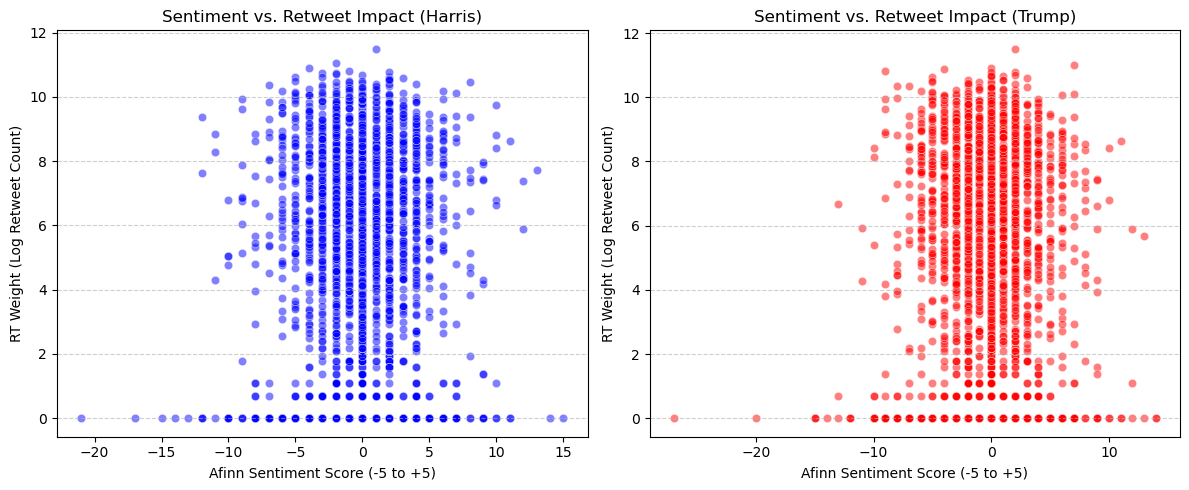

In [8]:
# Load sentiment-labeled datasets
afinn_harris_path = r"C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\afinn_sentiment_harris.csv"
afinn_trump_path = r"C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\afinn_sentiment_trump.csv"

df_harris = pd.read_csv(afinn_harris_path)
df_trump = pd.read_csv(afinn_trump_path)

# Ensure "RT Weight" is calculated (log transformation of retweets)
df_harris["RT_Weight"] = df_harris["Retweets"].apply(lambda x: np.log1p(x))
df_trump["RT_Weight"] = df_trump["Retweets"].apply(lambda x: np.log1p(x))

# Plot Sentiment vs. Retweet Impact for Harris
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x=df_harris["Afinn_Sentiment_Score"], y=df_harris["RT_Weight"], color="blue", alpha=0.5)
plt.title("Sentiment vs. Retweet Impact (Harris)")
plt.xlabel("Afinn Sentiment Score (-5 to +5)")
plt.ylabel("RT Weight (Log Retweet Count)")
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Plot Sentiment vs. Retweet Impact for Trump
plt.subplot(1, 2, 2)
sns.scatterplot(x=df_trump["Afinn_Sentiment_Score"], y=df_trump["RT_Weight"], color="red", alpha=0.5)
plt.title("Sentiment vs. Retweet Impact (Trump)")
plt.xlabel("Afinn Sentiment Score (-5 to +5)")
plt.ylabel("RT Weight (Log Retweet Count)")
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Show the plots
plt.tight_layout()
plt.show()

# 🔹 What Insights Can This Provide?
📌 Does positivity drive virality? If highly positive tweets have higher RT Weight, people engage more with positivity.
📌 Does negativity spread more? If strongly negative tweets get retweeted more, it suggests controversy drives engagement.
📌 Are neutral tweets ignored? If neutral tweets cluster at low RT Weight, it means engagement happens mostly with strong opinions.

# 3️⃣ Sentiment vs. Retweet Impact (Harris) (Bottom Left)
📌 This scatter plot shows how sentiment score correlates with retweet count for Harris’ tweets.
📌 Observations:

Retweets are scattered across all sentiment scores, meaning both positive and negative tweets get retweeted.
However, there is no clear trend that more positive or negative tweets get significantly higher retweets.
Most tweets have an RT Weight below 10, indicating that only a few tweets became highly viral.
# 4️⃣ Sentiment vs. Retweet Impact (Trump) (Bottom Right)
📌 This scatter plot shows the same sentiment-retweet correlation for Trump's tweets.
📌 Observations:

Trump’s tweets show a more dispersed pattern, meaning both strongly negative and strongly positive tweets can gain high engagement.
Similar to Harris, there is no clear trend that highly positive tweets go more viral than negative ones.
Trump’s dataset has more tweets that reached high RT Weight, suggesting his tweets had more viral moments.

# ✅ Step 12C: Sentiment Trends Over Time
Now we will track how sentiment changed over time based on the "Created at" column.

🔹 What This Step Does?
✅ Converts timestamps to datetime format.
✅ Aggregates average sentiment per day.
✅ Plots sentiment trends for Harris & Trump separately.

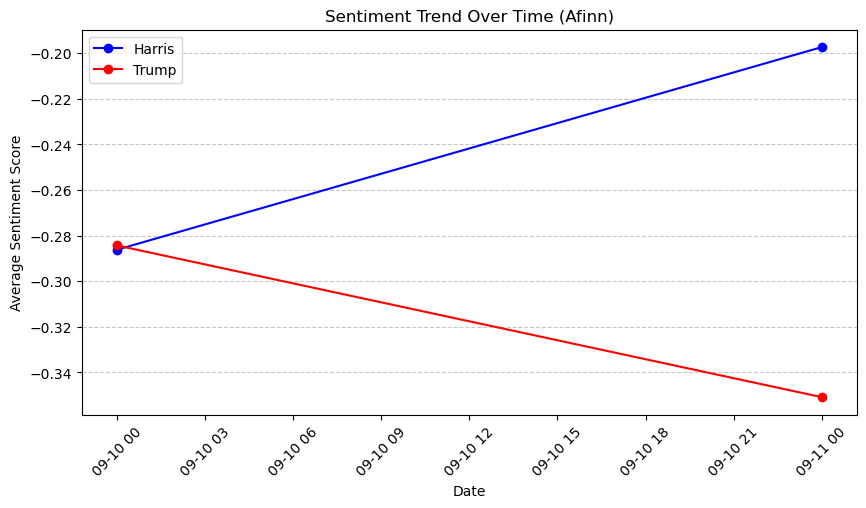

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Load sentiment-labeled datasets
afinn_harris_path = r"C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\afinn_sentiment_harris.csv"
afinn_trump_path = r"C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\afinn_sentiment_trump.csv"

df_harris = pd.read_csv(afinn_harris_path)
df_trump = pd.read_csv(afinn_trump_path)

# Convert "Created at" to datetime format
df_harris["Created at"] = pd.to_datetime(df_harris["Created at"])
df_trump["Created at"] = pd.to_datetime(df_trump["Created at"])

# Aggregate average sentiment by day
harris_sentiment_trend = df_harris.groupby(df_harris["Created at"].dt.date)["Afinn_Sentiment_Score"].mean()
trump_sentiment_trend = df_trump.groupby(df_trump["Created at"].dt.date)["Afinn_Sentiment_Score"].mean()

# Plot sentiment trends
plt.figure(figsize=(10, 5))
plt.plot(harris_sentiment_trend, label="Harris", color="blue", linestyle="-", marker="o")
plt.plot(trump_sentiment_trend, label="Trump", color="red", linestyle="-", marker="o")

plt.title("Sentiment Trend Over Time (Afinn)")
plt.xlabel("Date")
plt.ylabel("Average Sentiment Score")
plt.legend()
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()



# ✅ Step 12D: Most Extreme Sentiment Tweets
Now we will identify tweets with the most extreme sentiment scores to analyze the most positive and negative opinions.

🔹 What This Step Does?
✅ Finds the top 5 most positive and top 5 most negative tweets for Harris & Trump.
✅ Displays the tweets with their sentiment scores.
✅ Saves the extreme sentiment tweets to a CSV file for further analysis.

In [10]:
import pandas as pd

# Load sentiment-labeled datasets
afinn_harris_path = r"C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\afinn_sentiment_harris.csv"
afinn_trump_path = r"C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\afinn_sentiment_trump.csv"

df_harris = pd.read_csv(afinn_harris_path)
df_trump = pd.read_csv(afinn_trump_path)

# Get the top 5 most positive and top 5 most negative tweets for each dataset
most_positive_harris = df_harris.nlargest(5, "Afinn_Sentiment_Score")[["Tweet", "Afinn_Sentiment_Score"]]
most_negative_harris = df_harris.nsmallest(5, "Afinn_Sentiment_Score")[["Tweet", "Afinn_Sentiment_Score"]]

most_positive_trump = df_trump.nlargest(5, "Afinn_Sentiment_Score")[["Tweet", "Afinn_Sentiment_Score"]]
most_negative_trump = df_trump.nsmallest(5, "Afinn_Sentiment_Score")[["Tweet", "Afinn_Sentiment_Score"]]

# Combine extreme sentiment tweets into one DataFrame
df_extreme_sentiments = pd.concat([
    most_positive_harris.assign(Source="Harris", Sentiment="Most Positive"),
    most_negative_harris.assign(Source="Harris", Sentiment="Most Negative"),
    most_positive_trump.assign(Source="Trump", Sentiment="Most Positive"),
    most_negative_trump.assign(Source="Trump", Sentiment="Most Negative")
])

# Save the dataset
extreme_sentiment_path = r"C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\extreme_sentiment_tweets.csv"
df_extreme_sentiments.to_csv(extreme_sentiment_path, index=False)

print("\n✅ Extreme Sentiment Analysis Completed!")
print(f"✅ Most Extreme Sentiment Tweets saved at: {extreme_sentiment_path}")

# Display extreme sentiment tweets
print("\n🔹 Most Positive Harris Tweets:")
print(most_positive_harris)

print("\n🔹 Most Negative Harris Tweets:")
print(most_negative_harris)

print("\n🔹 Most Positive Trump Tweets:")
print(most_positive_trump)

print("\n🔹 Most Negative Trump Tweets:")
print(most_negative_trump)



✅ Extreme Sentiment Analysis Completed!
✅ Most Extreme Sentiment Tweets saved at: C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Twitter Analysis1\extreme_sentiment_tweets.csv

🔹 Most Positive Harris Tweets:
                                                  Tweet  Afinn_Sentiment_Score
796   @AVindman It was wonderful to see you on the H...                   15.0
804   Exciting news: Kamala Harris is the clear favo...                   14.0
2533  RT @Morning_Joe: "Kamala Harris was superb. Sh...                   13.0
231   RT @BoLoudon: WOW! If you love animals like I ...                   12.0
829   RT @AlsobrooksForMD: The post-DNC support has ...                   12.0

🔹 Most Negative Harris Tweets:
                                                  Tweet  Afinn_Sentiment_Score
2022  ABC  couldn’t face KAMALAs BRUTAL Destruction ...                  -21.0
1155  @WesternLensman Piece of Shit Schiff and all t...                  -17.0
95    NO chameleon  harri